In [1]:
library(tidyverse)
library(RColorBrewer)
library(cowplot)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
############################################################################
#                                                                          #
#                          SET PARAMETERS HERE                             #
#                                                                          #
############################################################################

# ci5_cs1e9        all_germline_filtered_bams_tumor_ci5_cs1e9
input_folder_target_ratios = "all_germline_filtered_bams_tumor_ci5_cs1e9"
# ratio_singletons_excluded_tumor_4_cs     ratio
filetype_target_ratios = "ratio"

# ratio_emp_dist_analysis_ci4_cs1e9    ratio_emp_dist_analysis_all_germline_filtered_tumor_bams_ci5_cs1e9
input_folder_ratios_dist = "ratio_emp_dist_analysis_all_germline_filtered_tumor_bams_ci5_cs1e9"
output_folder = "union_germline_filtered_tumor_bams_ci5_cs1e9"

In [3]:
paramspace_emp <- read.csv("../data/metadata/paramspace_empirical_dist_analysis_phaseI.csv", sep = ",")
dim(paramspace_emp)
head(paramspace_emp)

[1] 2660    5

X,patient_id,unique_tumor_kmers_folder,other_patient_id,other_patient_cfDNA_folder
0,C04689,C123T04689D_frfr_N295-450,C04849,C258A04849D_cfdna_N295-141
1,C04689,C123T04689D_frfr_N295-450,C04849,C255A04849D_cfdna_N295-87
2,C04689,C123T04689D_frfr_N295-450,C04849,C194A04849D_cfdna_N295-218
3,C04689,C123T04689D_frfr_N295-450,C04849,C252A04849D_cfdna_N295-64
4,C04689,C123T04689D_frfr_N295-450,C04849,C256A04849D_cfdna_N295-115
5,C04689,C123T04689D_frfr_N295-450,C04849,C263A04849D_cfdna_N295-222


In [4]:
paramspace_cfDNA <- read.csv("../data/metadata/paramspace_cfDNA_phaseI.csv", sep = ",")
paramspace_cfDNA  <- paramspace_cfDNA %>% rename(patient_id = pt_id)
dim(paramspace_cfDNA)

[1] 190   5

In [5]:
paramspace_cfDNA["big_ratio"] <- NA
paramspace_cfDNA["big_ratio_CI_lower"] <- NA
paramspace_cfDNA["big_ratio_CI_upper"] <- NA

paramspace_cfDNA["small_ratio"] <- NA
paramspace_cfDNA["small_ratio_CI_lower"] <- NA
paramspace_cfDNA["small_ratio_CI_upper"] <- NA

for (row in 1:nrow(paramspace_cfDNA)){
    pt = paramspace_cfDNA[row, "patient_id"]
    #print(pt)
    fd = paramspace_cfDNA[row, "cfDNA_folder"]
    big_r = read.csv(paste("../data/", pt, "/" , fd, "/", input_folder_target_ratios, "/", "big_", filetype_target_ratios, ".csv", sep = ""))
    small_r = read.csv(paste("../data/", pt, "/", fd, "/", input_folder_target_ratios, "/", "small_", filetype_target_ratios, ".csv", sep = ""))
    #print(big_r[[1]])
    #print(small_r[[1]])
    paramspace_cfDNA[row, "big_ratio"] = big_r$ratio
    paramspace_cfDNA[row, "big_ratio_CI_lower"] = big_r$lower_CI
    paramspace_cfDNA[row, "big_ratio_CI_upper"] = big_r$upper_CI
    
    paramspace_cfDNA[row, "small_ratio"] = small_r$ratio
    paramspace_cfDNA[row, "small_ratio_CI_lower"] = small_r$lower_CI
    paramspace_cfDNA[row, "small_ratio_CI_upper"] = small_r$upper_CI
}

In [6]:
paramspace_cfDNA <- paramspace_cfDNA %>% 
  mutate(tmp_chunks = stringr::str_split(cfDNA_folder, stringr::fixed("_"),  n = 3)) %>%
  mutate(sampleID = map_chr(tmp_chunks, 1),
         sub_value = map_chr(tmp_chunks, 2), 
         sub_val = map_chr(tmp_chunks, 3)) %>%
  select(-c(tmp_chunks, sub_value, sub_val))

head(paramspace_cfDNA)
dim(paramspace_cfDNA)

patient_id,cfDNA_folder,cfDNA_file,cfDNA_bam_path,unique_kmers_folder,big_ratio,big_ratio_CI_lower,big_ratio_CI_upper,small_ratio,small_ratio_CI_lower,small_ratio_CI_upper,sampleID
C04689,C303A04689D_cfdna_N295-103,C303A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C303A04689D_cfdna_N295-103/C303A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04582955,0.04566917,0.04598480,0.06964383,0.06895091,0.07034158,C303A04689D
C04689,C305A04689D_cfdna_N295-71,C305A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C305A04689D_cfdna_N295-71/C305A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04521584,0.04506447,0.04536920,0.07109858,0.07039898,0.07180299,C305A04689D
C04689,C309A04689D_cfdna_N295-47,C309A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C309A04689D_cfdna_N295-47/C309A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04579486,0.04563624,0.04594922,0.06918862,0.06849780,0.06988427,C309A04689D
C04689,C302A04689D_cfdna_N295-102,C302A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C302A04689D_cfdna_N295-102/C302A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04630534,0.04615364,0.04645608,0.06993052,0.06923628,0.07062959,C302A04689D
C04689,C299A04689D_cfdna_N295-99,C299A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C299A04689D_cfdna_N295-99/C299A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04689660,0.04674539,0.04704417,0.08478404,0.08402554,0.08554722,C299A04689D
C04689,C307A04689D_cfdna_N295-110,C307A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C307A04689D_cfdna_N295-110/C307A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04635922,0.04620585,0.04651153,0.06986659,0.06917265,0.07056537,C307A04689D


[1] 190  12

In [7]:
sample_timepoint <- read.csv("../data/metadata/clin_data/sample_timepoint_formatted.csv")

In [8]:
sample_timepoint_days <- sample_timepoint %>% filter(phase == "phaseI")
sample_timepoint_days <- sample_timepoint_days %>% select(sampleID, sample_timepoint_days_since_OP)
print(sample_timepoint_days %>% filter(is.na(sample_timepoint_days_since_OP)))
dim(sample_timepoint_days)
head(sample_timepoint_days)

[1] sampleID                       sample_timepoint_days_since_OP
<0 rows> (or 0-length row.names)


[1] 190   2

sampleID,sample_timepoint_days_since_OP
C299A04689D,-1
C300A04689D,37
C301A04689D,93
C302A04689D,175
C303A04689D,267
C304A04689D,362


In [9]:
paramspace_cfDNA$sampleID <- as.character(paramspace_cfDNA$sampleID)
paramspace_cfDNA <- left_join(paramspace_cfDNA, sample_timepoint_days, by = c("sampleID"))
head(paramspace_cfDNA)
dim(paramspace_cfDNA)

patient_id,cfDNA_folder,cfDNA_file,cfDNA_bam_path,unique_kmers_folder,big_ratio,big_ratio_CI_lower,big_ratio_CI_upper,small_ratio,small_ratio_CI_lower,small_ratio_CI_upper,sampleID,sample_timepoint_days_since_OP
C04689,C303A04689D_cfdna_N295-103,C303A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C303A04689D_cfdna_N295-103/C303A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04582955,0.04566917,0.04598480,0.06964383,0.06895091,0.07034158,C303A04689D,267
C04689,C305A04689D_cfdna_N295-71,C305A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C305A04689D_cfdna_N295-71/C305A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04521584,0.04506447,0.04536920,0.07109858,0.07039898,0.07180299,C305A04689D,454
C04689,C309A04689D_cfdna_N295-47,C309A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C309A04689D_cfdna_N295-47/C309A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04579486,0.04563624,0.04594922,0.06918862,0.06849780,0.06988427,C309A04689D,820
C04689,C302A04689D_cfdna_N295-102,C302A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C302A04689D_cfdna_N295-102/C302A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04630534,0.04615364,0.04645608,0.06993052,0.06923628,0.07062959,C302A04689D,175
C04689,C299A04689D_cfdna_N295-99,C299A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C299A04689D_cfdna_N295-99/C299A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04689660,0.04674539,0.04704417,0.08478404,0.08402554,0.08554722,C299A04689D,-1
C04689,C307A04689D_cfdna_N295-110,C307A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C307A04689D_cfdna_N295-110/C307A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04635922,0.04620585,0.04651153,0.06986659,0.06917265,0.07056537,C307A04689D,637


[1] 190  13

In [10]:
getPalette = colorRampPalette(brewer.pal(9, "Blues"))

In [11]:
head(paramspace_emp)

X,patient_id,unique_tumor_kmers_folder,other_patient_id,other_patient_cfDNA_folder
0,C04689,C123T04689D_frfr_N295-450,C04849,C258A04849D_cfdna_N295-141
1,C04689,C123T04689D_frfr_N295-450,C04849,C255A04849D_cfdna_N295-87
2,C04689,C123T04689D_frfr_N295-450,C04849,C194A04849D_cfdna_N295-218
3,C04689,C123T04689D_frfr_N295-450,C04849,C252A04849D_cfdna_N295-64
4,C04689,C123T04689D_frfr_N295-450,C04849,C256A04849D_cfdna_N295-115
5,C04689,C123T04689D_frfr_N295-450,C04849,C263A04849D_cfdna_N295-222


In [12]:
Correlations <- read.csv("../data/ci5_cs1e9_correlation.csv")
relapse_label <- Correlations %>% select(cfDNA_sample, Relapse)
colnames(relapse_label) <- c("cfDNA_folder", "Relapse_label")

In [13]:
dim(paramspace_cfDNA)

[1] 190  13

In [14]:
paramspace_cfDNA <- left_join(paramspace_cfDNA, relapse_label, by = "cfDNA_folder")
head(paramspace_cfDNA)

patient_id,cfDNA_folder,cfDNA_file,cfDNA_bam_path,unique_kmers_folder,big_ratio,big_ratio_CI_lower,big_ratio_CI_upper,small_ratio,small_ratio_CI_lower,small_ratio_CI_upper,sampleID,sample_timepoint_days_since_OP,Relapse_label
C04689,C303A04689D_cfdna_N295-103,C303A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C303A04689D_cfdna_N295-103/C303A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04582955,0.04566917,0.04598480,0.06964383,0.06895091,0.07034158,C303A04689D,267,No_relapse
C04689,C305A04689D_cfdna_N295-71,C305A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C305A04689D_cfdna_N295-71/C305A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04521584,0.04506447,0.04536920,0.07109858,0.07039898,0.07180299,C305A04689D,454,No_relapse
C04689,C309A04689D_cfdna_N295-47,C309A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C309A04689D_cfdna_N295-47/C309A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04579486,0.04563624,0.04594922,0.06918862,0.06849780,0.06988427,C309A04689D,820,No_relapse
C04689,C302A04689D_cfdna_N295-102,C302A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C302A04689D_cfdna_N295-102/C302A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04630534,0.04615364,0.04645608,0.06993052,0.06923628,0.07062959,C302A04689D,175,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C299A04689D_cfdna_N295-99/C299A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04689660,0.04674539,0.04704417,0.08478404,0.08402554,0.08554722,C299A04689D,-1,No_relapse
C04689,C307A04689D_cfdna_N295-110,C307A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C307A04689D_cfdna_N295-110/C307A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450,0.04635922,0.04620585,0.04651153,0.06986659,0.06917265,0.07056537,C307A04689D,637,No_relapse


In [15]:
paramspace_cfDNA %>% filter(patient_id == "C05048")

patient_id,cfDNA_folder,cfDNA_file,cfDNA_bam_path,unique_kmers_folder,big_ratio,big_ratio_CI_lower,big_ratio_CI_upper,small_ratio,small_ratio_CI_lower,small_ratio_CI_upper,sampleID,sample_timepoint_days_since_OP,Relapse_label
C05048,C275A05048D_cfdna_N295-123,C275A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C275A05048D_cfdna_N295-123/C275A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0003133879,0.0003051303,0.0003212601,0.002620707,0.002513496,0.002731306,C275A05048D,273,No_relapse
C05048,C75A05048D_cfdna_N295-233,C75A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C75A05048D_cfdna_N295-233/C75A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0024833689,0.0024561765,0.0025099398,0.019200211,0.018910528,0.019493155,C75A05048D,-1,No_relapse
C05048,C284A05048D_cfdna_N295-210,C284A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C284A05048D_cfdna_N295-210/C284A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0004466285,0.0004332439,0.0004597490,0.002217611,0.002119059,0.002319556,C284A05048D,1057,No_relapse
C05048,C274A05048D_cfdna_N295-111,C274A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C274A05048D_cfdna_N295-111/C274A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0003287512,0.0003200224,0.0003375380,0.002909300,0.002796296,0.003025689,C274A05048D,182,No_relapse
C05048,C282A05048D_cfdna_N295-199,C282A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C282A05048D_cfdna_N295-199/C282A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0003397687,0.0003275917,0.0003522217,0.001688329,0.001602458,0.001777600,C282A05048D,919,No_relapse
C05048,C283A05048D_cfdna_N295-207,C283A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C283A05048D_cfdna_N295-207/C283A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0003425557,0.0003297629,0.0003552643,0.001400904,0.001322772,0.001482441,C283A05048D,1003,No_relapse
C05048,C280A05048D_cfdna_N295-176,C280A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C280A05048D_cfdna_N295-176/C280A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0003378622,0.0003292479,0.0003466571,0.002591497,0.002484890,0.002701493,C280A05048D,734,No_relapse
C05048,C273A05048D_cfdna_N295-89,C273A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C273A05048D_cfdna_N295-89/C273A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0007753444,0.0007624764,0.0007881468,0.006139908,0.005975502,0.006307670,C273A05048D,111,No_relapse
C05048,C278A05048D_cfdna_N295-151,C278A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C278A05048D_cfdna_N295-151/C278A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0002801874,0.0002725343,0.0002877478,0.002702494,0.002593610,0.002814766,C278A05048D,555,No_relapse
C05048,C281A05048D_cfdna_N295-193,C281A05048D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C05048/C281A05048D_cfdna_N295-193/C281A05048D_cfdna.aligned.sorted.markdup.bam,C74T05048D_frfr_N295-458,0.0003056055,0.0002969828,0.0003144453,0.002460637,0.002356778,0.002567886,C281A05048D,821,No_relapse


In [16]:
plots <- NULL
plots_grid <- NULL
plots_small <- NULL
plots_grid_small <- NULL
p_vals_all <- NULL

for (pt in unique(paramspace_emp$patient_id)){
    paramspace_emp_pt <- paramspace_emp %>% filter(patient_id == pt)
    paramspace_cfDNA_pt <- paramspace_cfDNA %>% filter(patient_id == pt)
    
    paramspace_emp_pt["big_ratio"] <- NA
    paramspace_emp_pt["small_ratio"] <- NA
    
    for (row in 1:nrow(paramspace_emp_pt)){
        other_pt = paramspace_emp_pt[row, "other_patient_id"]
        other_pt_cfDNA_folder = paramspace_emp_pt[row, "other_patient_cfDNA_folder"]
        index  = paramspace_emp_pt[row, "X"]
        big_r = read.csv(paste("../data/", pt, "/" , input_folder_ratios_dist, "/ratios/", "big_ratio_pt_", other_pt, "_cfDNAsample_", other_pt_cfDNA_folder, "_", index, ".csv", sep = ""))
        small_r = read.csv(paste("../data/", pt, "/" , input_folder_ratios_dist, "/small_ratios/", "small_ratio_pt_", other_pt, "_cfDNAsample_", other_pt_cfDNA_folder, "_", index, ".csv", sep = ""))
        paramspace_emp_pt[row, "big_ratio"] = big_r$ratio
        paramspace_emp_pt[row, "small_ratio"] = small_r$ratio
    }
    ratios_other = paramspace_emp_pt$big_ratio
    ratios_other = sort(ratios_other, decreasing = FALSE)
    paramspace_cfDNA_pt["p_value"] <- NA
    
    ratios_other_small = paramspace_emp_pt$small_ratio
    ratios_other_small = sort(ratios_other_small, decreasing = FALSE)
    paramspace_cfDNA_pt["p_value"] <- NA
    paramspace_cfDNA_pt["p_value_small_r"] <- NA
    
    for (row in 1:nrow(paramspace_cfDNA_pt)){
        ratio = paramspace_cfDNA_pt[row, "big_ratio"]
        paramspace_cfDNA_pt[row, "p_value"] = sum(ratios_other >= ratio)/length(ratios_other)
        
        small_ratio = paramspace_cfDNA_pt[row, "small_ratio"]
        paramspace_cfDNA_pt[row, "p_value_small_r"] = sum(ratios_other_small >= small_ratio)/length(ratios_other_small)
        }
    p_vals_all <- rbind(p_vals_all, paramspace_cfDNA_pt)
    
    
    paramspace_cfDNA_pt$sample_timepoint <- as.factor(paramspace_cfDNA_pt$sample_timepoint)
    colourCount = length(unique(paramspace_cfDNA_pt$sample_timepoint))
    
    distribution_plot <- ggplot() + 
                              geom_histogram(data = paramspace_emp_pt, aes(x = big_ratio), fill = "grey81", color = "grey50", bins = 70) + 
                              geom_vline(data = paramspace_cfDNA_pt, aes(xintercept = big_ratio, color = sample_timepoint), size = 0.5, alpha = 1) + 
                              theme_minimal()  + 
                              scale_color_manual(values = getPalette(colourCount)) + 
                              labs(x = "Big ratio",
                                   y = "count", 
                                   title = paste("Big ratio distribution", sep =  ""),
                                   subtitle = paste("Patient ", pt, " (", paramspace_cfDNA_pt[1, "Relapse_label"], ")", "\nPipeline ", input_folder_target_ratios, sep =  ""))
    
     distribution_plot_cowplot <- ggplot() + 
                              geom_histogram(data = paramspace_emp_pt, aes(x = big_ratio), fill = "grey81", color = "grey50", bins = 70) + 
                              geom_vline(data = paramspace_cfDNA_pt, aes(xintercept = big_ratio, color = sample_timepoint), size = 0.5, alpha = 1) + 
                              theme_minimal()  + 
                              scale_color_manual(values = getPalette(colourCount)) + 
                              labs(x = "Big ratio",
                                   y = "count", 
                                   title = paste(pt, " (", paramspace_cfDNA_pt[1, "Relapse_label"], ")", sep =  "")) +
                              theme(legend.position = "none")
    
    ggsave(
      paste("../plotting_results/", output_folder, "/empirical_dist_analysis/big_ratios/Patient_", pt, "_Big_ratio_distribution.png", sep = ""),
      distribution_plot, dpi = "print")
    
    ######################################################################################################################################
    ######################################################################################################################################
    ######################################################################################################################################
    
    distribution_plot_small <- ggplot() + 
                              geom_histogram(data = paramspace_emp_pt, aes(x = small_ratio), fill = "grey81", color = "grey50", bins = 70) + 
                              geom_vline(data = paramspace_cfDNA_pt, aes(xintercept = small_ratio, color = sample_timepoint), size = 0.5, alpha = 1) + 
                              theme_minimal()  + 
                              scale_color_manual(values = getPalette(colourCount)) + 
                              labs(x = "Small ratio",
                                   y = "count", 
                                   title = paste("Small ratio distribution", sep =  ""),
                                   subtitle = paste("Patient ", pt, " (", paramspace_cfDNA_pt[1, "Relapse_label"], ")", "\nPipeline ", input_folder_target_ratios, sep =  ""))
    
     distribution_plot_cowplot_small <- ggplot() + 
                              geom_histogram(data = paramspace_emp_pt, aes(x = small_ratio), fill = "grey81", color = "grey50", bins = 70) + 
                              geom_vline(data = paramspace_cfDNA_pt, aes(xintercept = small_ratio, color = sample_timepoint), size = 0.5, alpha = 1) + 
                              theme_minimal()  + 
                              scale_color_manual(values = getPalette(colourCount)) + 
                              labs(x = "Small ratio",
                                   y = "count", 
                                   title = paste(pt, " (", paramspace_cfDNA_pt[1, "Relapse_label"], ")", sep =  "")) +
                              theme(legend.position = "none")
    
    ggsave(
      paste("../plotting_results/", output_folder, "/empirical_dist_analysis/small_ratios/Patient_", pt, "_Small_ratio_distribution.png", sep = ""),
      distribution_plot_small, dpi = "print")

    
    plots[[pt]] <- distribution_plot
    plots_grid[[pt]] <- distribution_plot_cowplot
    
    plots_small[[pt]] <- distribution_plot_small
    plots_grid_small[[pt]] <- distribution_plot_cowplot_small
    
    }

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


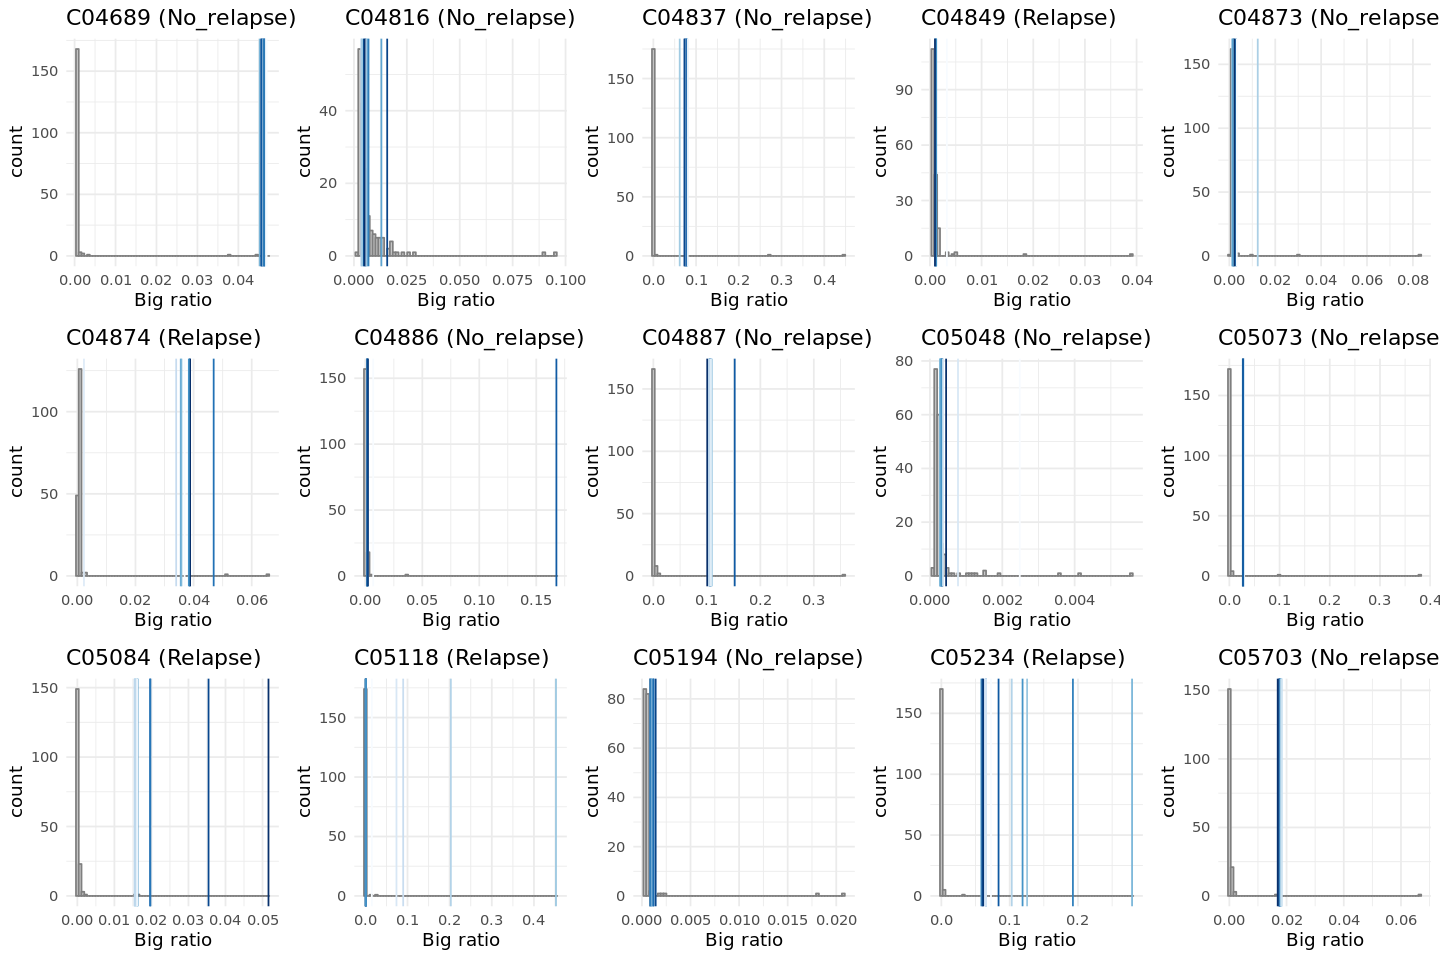

In [23]:
options(repr.plot.width=12, repr.plot.height=8)
combined_plot <- plot_grid(plots_grid[["C04689"]], plots_grid[["C04816"]], plots_grid[["C04837"]], plots_grid[["C04849"]], plots_grid[["C04873"]], 
          plots_grid[["C04874"]], plots_grid[["C04886"]], plots_grid[["C04887"]], plots_grid[["C05048"]], plots_grid[["C05073"]],
          plots_grid[["C05084"]], plots_grid[["C05118"]], plots_grid[["C05194"]], plots_grid[["C05234"]], plots_grid[["C05703"]], label_size = 5, ncol = 5)

combined_plot

ggsave(
      paste("../plotting_results/", output_folder, "/empirical_dist_analysis/big_ratios/Combined_plots_Big_ratio_distribution.png", sep = ""),
      combined_plot, width = 15, height = 8, dpi = "print")

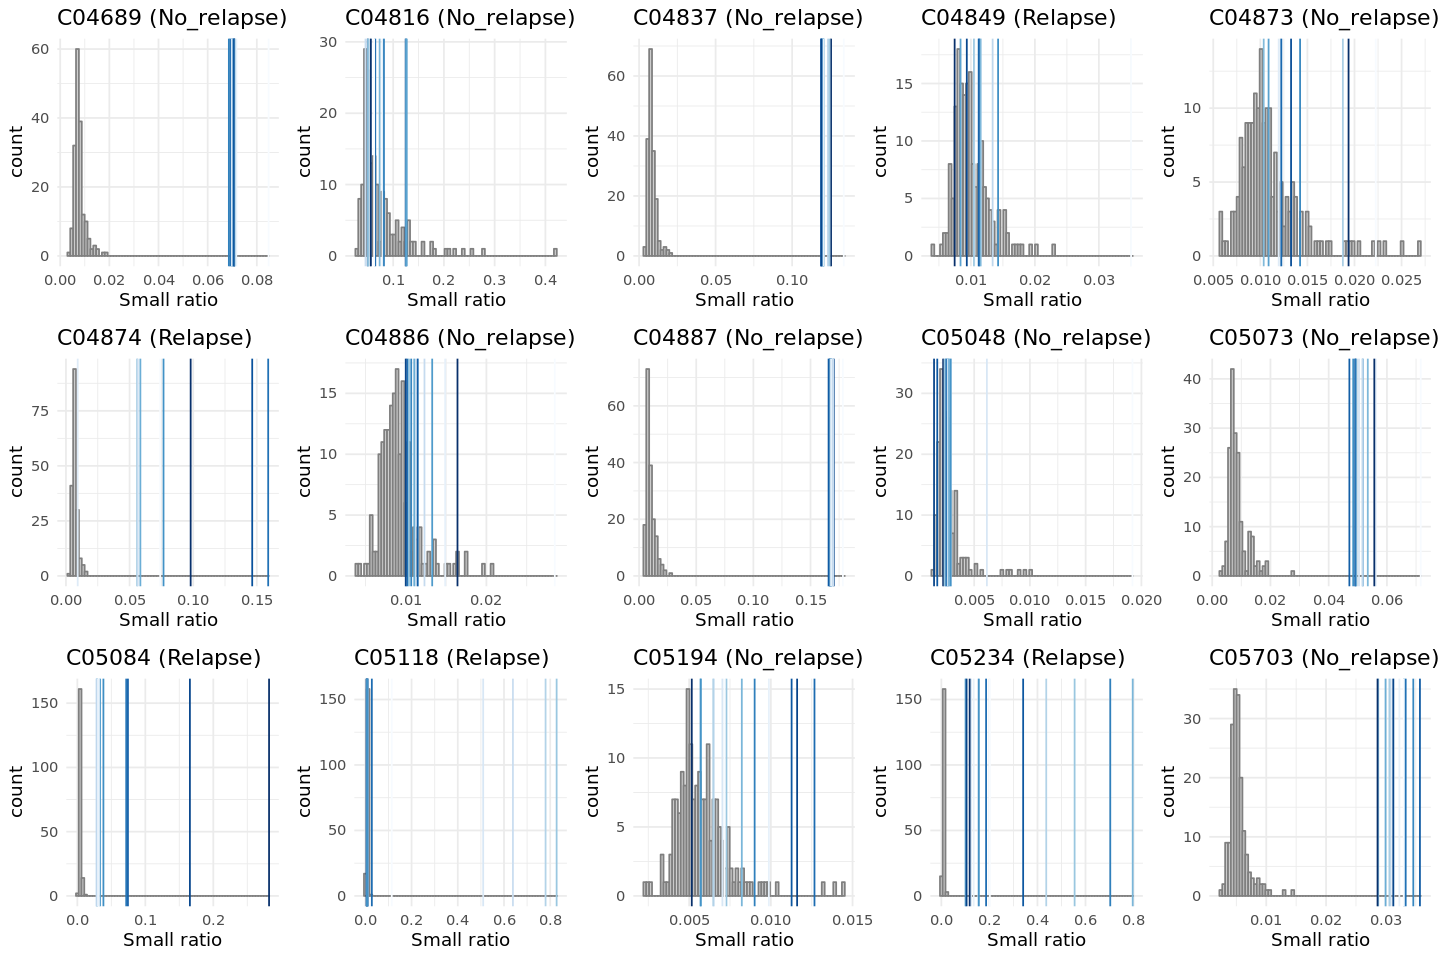

In [18]:
options(repr.plot.width=12, repr.plot.height=8)
combined_plot_small <- plot_grid(plots_grid_small[["C04689"]], plots_grid_small[["C04816"]], plots_grid_small[["C04837"]], plots_grid_small[["C04849"]], plots_grid_small[["C04873"]], 
          plots_grid_small[["C04874"]], plots_grid_small[["C04886"]], plots_grid_small[["C04887"]], plots_grid_small[["C05048"]], plots_grid_small[["C05073"]],
          plots_grid_small[["C05084"]], plots_grid_small[["C05118"]], plots_grid_small[["C05194"]], plots_grid_small[["C05234"]], plots_grid_small[["C05703"]], label_size = 5, ncol = 5)

combined_plot_small

ggsave(
      paste("../plotting_results/", output_folder, "/empirical_dist_analysis/small_ratios/Combined_plots_Small_ratio_distribution.png", sep = ""),
      combined_plot_small, width = 15, height = 8, dpi = "print")

## Calculate p-values

In [19]:
dim(paramspace_cfDNA)

[1] 190  14

In [20]:
dim(p_vals_all)

[1] 190  16

In [21]:
p_vals_all <- p_vals_all %>% select(patient_id, cfDNA_folder, unique_kmers_folder, big_ratio, small_ratio, sampleID, sample_timepoint_days_since_OP, Relapse_label, p_value, p_value_small_r)
head(p_vals_all)

patient_id,cfDNA_folder,unique_kmers_folder,big_ratio,small_ratio,sampleID,sample_timepoint_days_since_OP,Relapse_label,p_value,p_value_small_r
C04689,C303A04689D_cfdna_N295-103,C123T04689D_frfr_N295-450,0.04582955,0.06964383,C303A04689D,267,No_relapse,0,0
C04689,C305A04689D_cfdna_N295-71,C123T04689D_frfr_N295-450,0.04521584,0.07109858,C305A04689D,454,No_relapse,0,0
C04689,C309A04689D_cfdna_N295-47,C123T04689D_frfr_N295-450,0.04579486,0.06918862,C309A04689D,820,No_relapse,0,0
C04689,C302A04689D_cfdna_N295-102,C123T04689D_frfr_N295-450,0.04630534,0.06993052,C302A04689D,175,No_relapse,0,0
C04689,C299A04689D_cfdna_N295-99,C123T04689D_frfr_N295-450,0.04689660,0.08478404,C299A04689D,-1,No_relapse,0,0
C04689,C307A04689D_cfdna_N295-110,C123T04689D_frfr_N295-450,0.04635922,0.06986659,C307A04689D,637,No_relapse,0,0


In [22]:
write.csv(p_vals_all,  paste("../plotting_results/", output_folder, "/empirical_dist_analysis/p_values.csv", sep = ""), row.names = FALSE)